# Домашнее задание по теме «Элементарные методы анализа временных рядов»

Задание

    Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.
    Приблизьте оба варианта моделями из класса MA.
    Оцените качество и пришлите соображения, почему была выбрана та или иная модель.



### импорт библиотек

In [193]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from numpy import log
%matplotlib inline
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

### загрузка данных

In [10]:
# берем 2 ряда: стационарный по рождаемости и нестационарный по авиабилетам
!wget https://raw.githubusercontent.com/lteplova/tsml/main/Series/daily-total-female-births-in-cal.csv
!wget https://raw.githubusercontent.com/lteplova/tsml/main/Series/international-airline-passengers.csv


--2023-05-28 10:41:10--  https://raw.githubusercontent.com/lteplova/tsml/main/Series/daily-total-female-births-in-cal.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5856 (5.7K) [text/plain]
Saving to: ‘daily-total-female-births-in-cal.csv.1’

daily-total-female- 100%[===================>]   5.72K  --.-KB/s    in 0s      

2023-05-28 10:41:11 (56.3 MB/s) - ‘daily-total-female-births-in-cal.csv.1’ saved [5856/5856]

--2023-05-28 10:41:11--  https://raw.githubusercontent.com/lteplova/tsml/main/Series/international-airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected

In [20]:
airlines_passengers = pd.read_csv("international-airline-passengers.csv")["Count"]
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")["Count"]

### вспомогательные функции для расчета MA

In [22]:
# расчет статистик
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [23]:
# построение графиков распределения и автокорреляции
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [13]:
# скользящее среднее (MA)
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [14]:
# скользящее среднее с весами (WMA)
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [15]:
# EMA
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [199]:
# DEMA
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

# построение гарфика с результатами применения DEMA
def plot_dema(alpha, beta):
    dema = double_ema(sales_of_company_x["Count"], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(sales_of_company_x["Count"], color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [ ]:
# TEMA

In [46]:
def initial_trend(series, season_len):
    sum = 0.0
    for i in range(season_len):
        sum += float(series[i+season_len] - series[i]) / season_len
    return sum / season_len

In [41]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [42]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [176]:
# график результата TEMA
def plot_tema(alpha, beta, gamma, ser=sales_of_company_x["Count"], ser_to_plot=sales_of_company_x["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [160]:
# график результата TEMA с отображением метода
def plot_tema_m(alpha, beta, gamma, method, ser=sales_of_company_x["Count"], ser_to_plot=sales_of_company_x["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}, method={}".format(alpha, beta, gamma, method))
        plt.legend()

In [184]:
# Функция расчета ошибки
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [185]:
# Функция расчета ошибки с кроссвалидацией
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

### анализ первого ряда с авиаперелетами

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


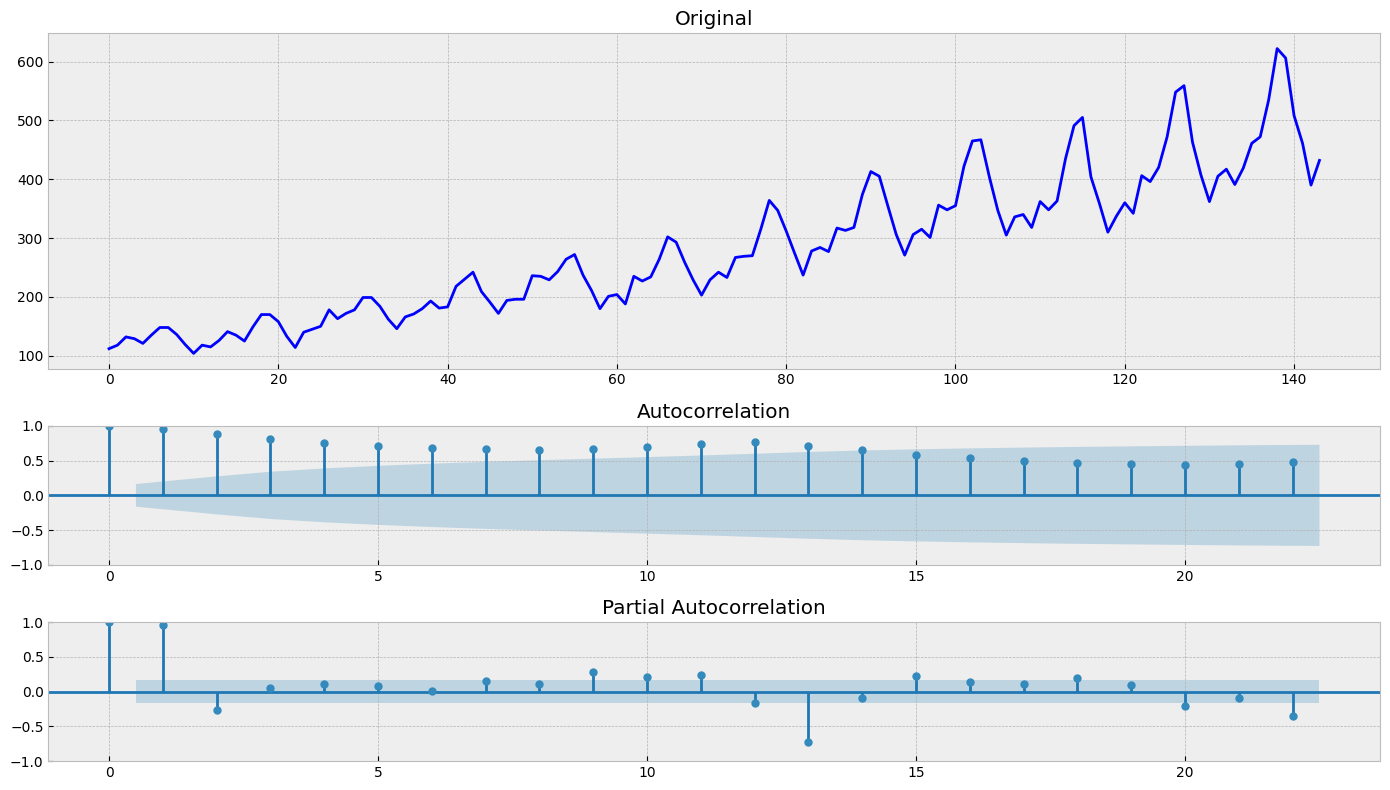

In [181]:
series = airlines_passengers 
tsplot(series)

По графику видно наличие тренда и сезонности, нестационарность ряда

Так как присутствует сезонность, то пробуем модель TEMA

#### оптимизация и TEMA

In [209]:
series = airlines_passengers 

In [210]:
# делим на тест, трейн, вилидационную выборки
train, test, val = series[:100], series[100:130], series[130:]

In [211]:
# оптимизация 
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [212]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1491.227685913543
        x: [ 1.000e+00  2.596e-02  1.000e+00]
      nit: 8
      jac: [-5.433e+02 -9.095e-05 -0.000e+00]
     nfev: 76
     njev: 19
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


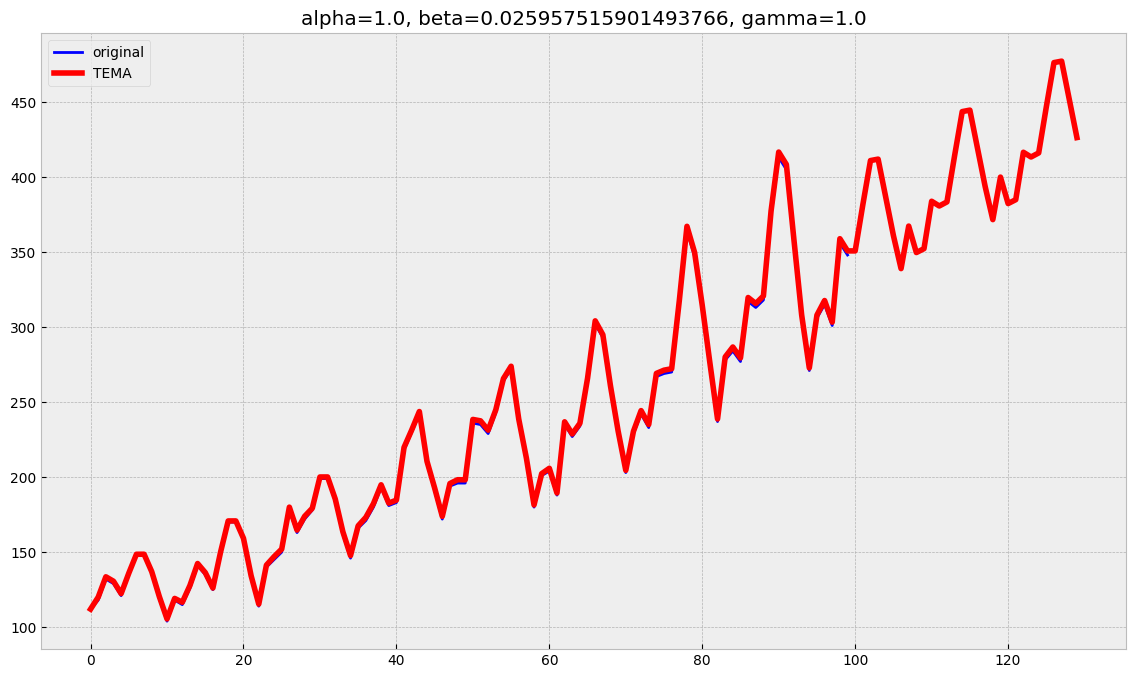

In [213]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=train, n_preds=len(test))

#### кроссвалидация

In [ ]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))

In [215]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 407.34717155227304
             x: [ 4.644e-01  2.595e-01  0.000e+00]
           nit: 195
          nfev: 341
 final_simplex: (array([[ 4.644e-01,  2.595e-01,  0.000e+00],
                       [ 4.643e-01,  2.596e-01,  0.000e+00],
                       [ 4.644e-01,  2.595e-01,  0.000e+00],
                       [ 4.644e-01,  2.594e-01,  0.000e+00]]), array([ 4.073e+02,  4.073e+02,  4.073e+02,  4.073e+02]))


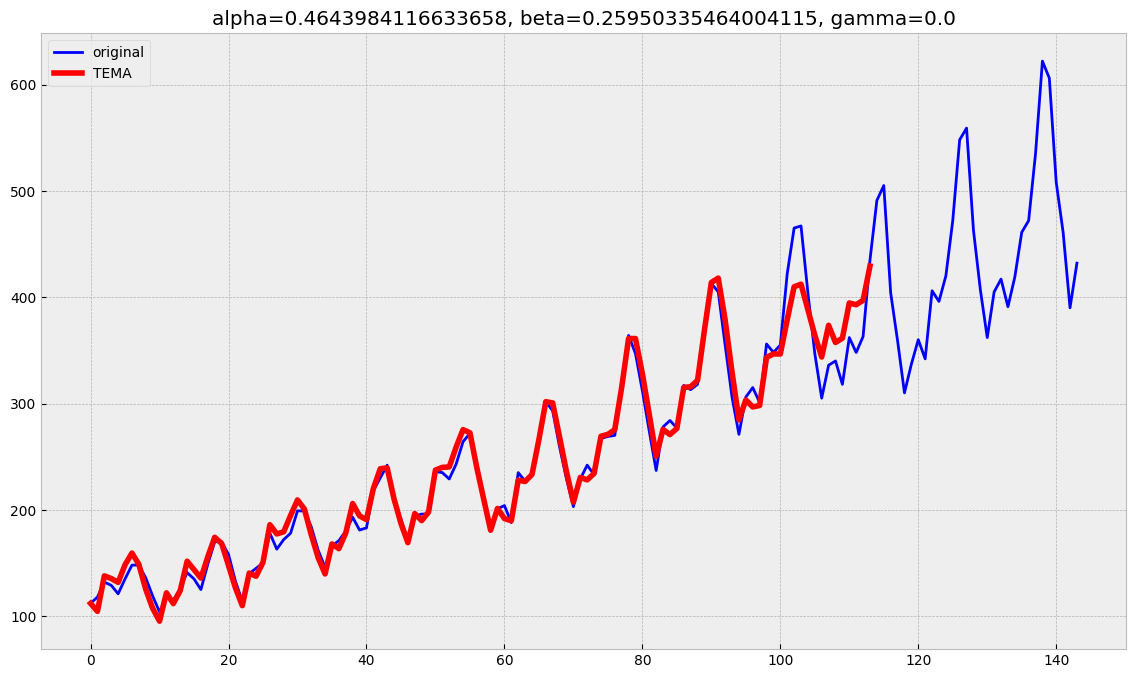

In [217]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))

In [ ]:
# оптимизация с перебором разных методов
method = ['Nelder-Mead', 'Powell', 'L-BFGS-B', 'TNC', 'SLSQP', 'trust-constr'] # перебор по методам
res_opt = {}
for i in method:
    opt = minimize(mse_cross_val, x0=[0,0,0], method=i, bounds = ((0, 1), (0, 1), (0, 1)))
    res_opt[i] = opt

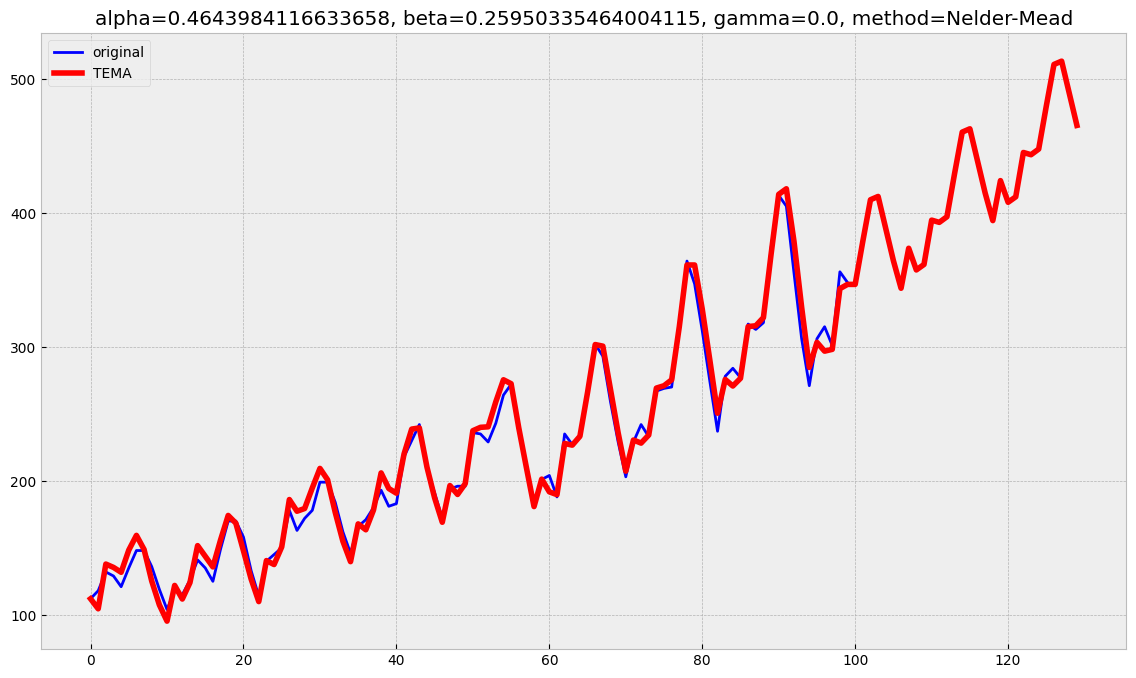

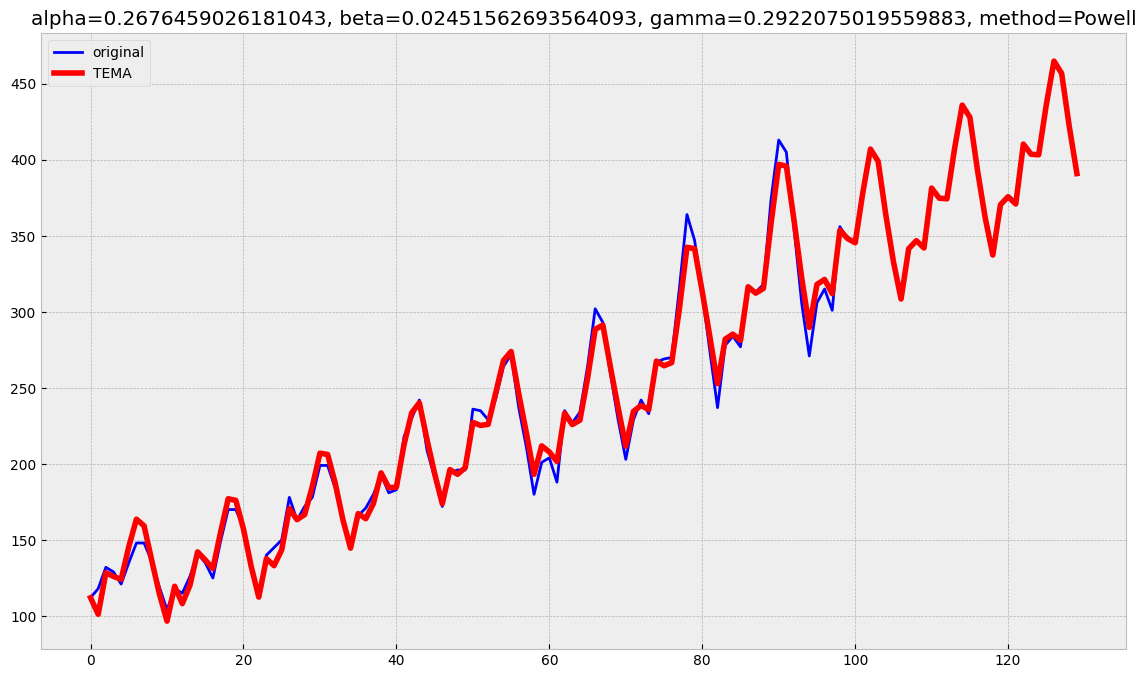

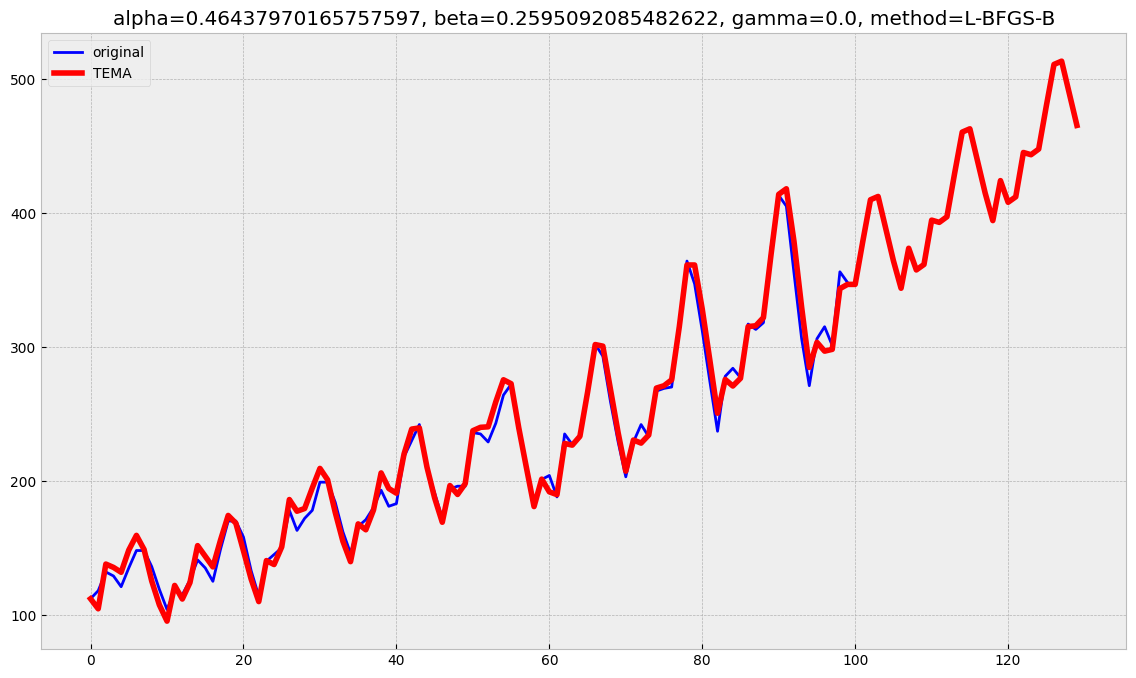

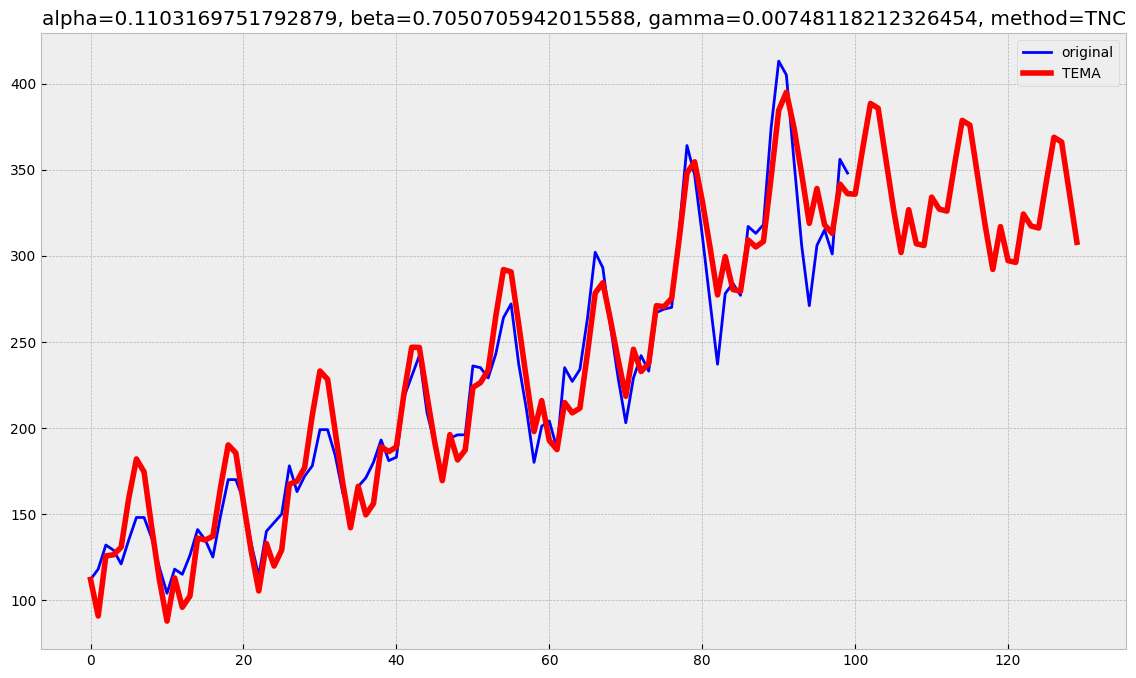

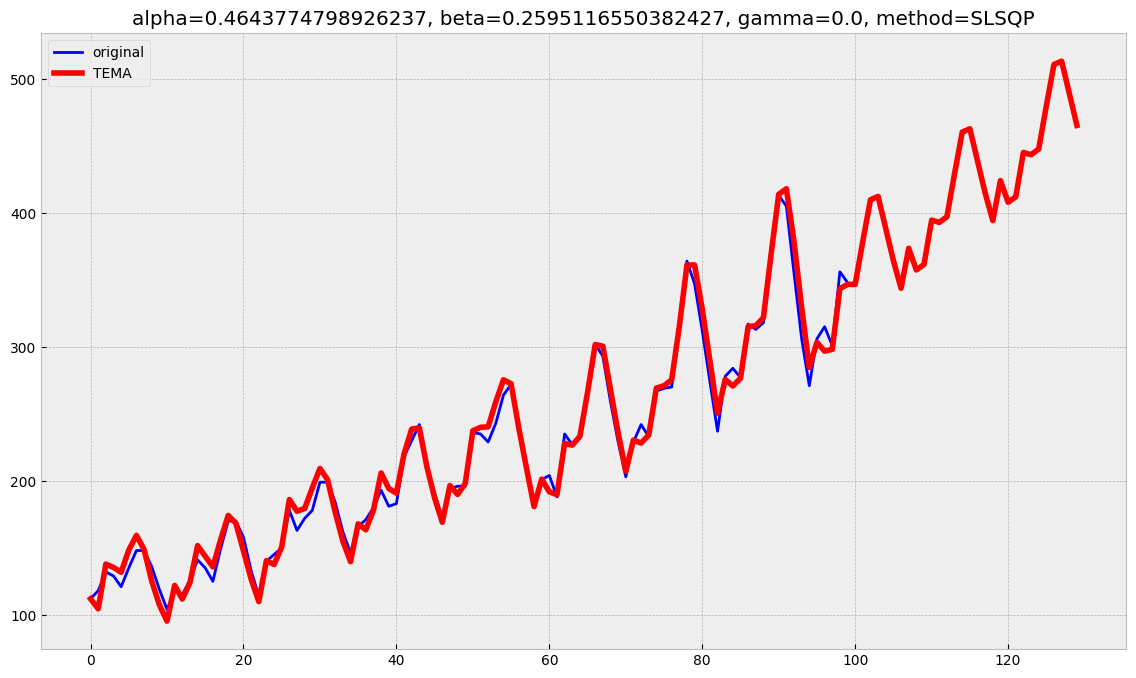

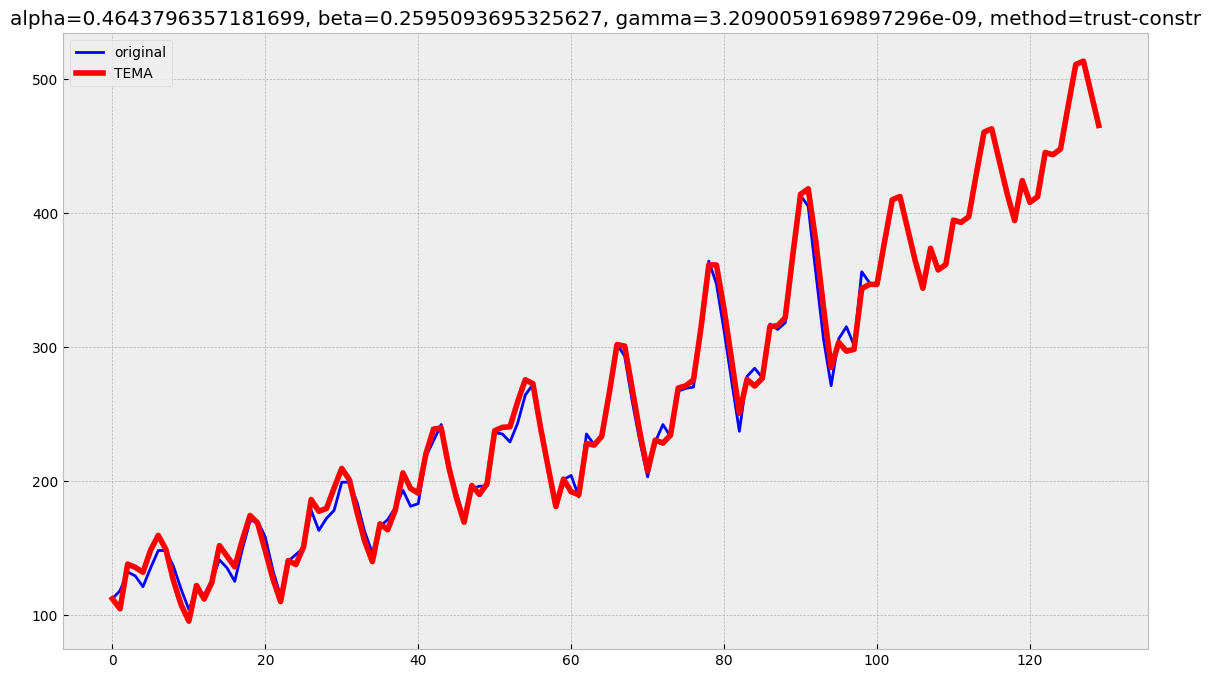

In [219]:
for k, v in res_opt.items():
    alpha_opt, beta_opt, gamma_opt = v.x
    plot_tema_m(alpha_opt, beta_opt, gamma_opt, k, ser=train, ser_to_plot=train, n_preds=len(test))

### анализ второго ряда с рождаемостью

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


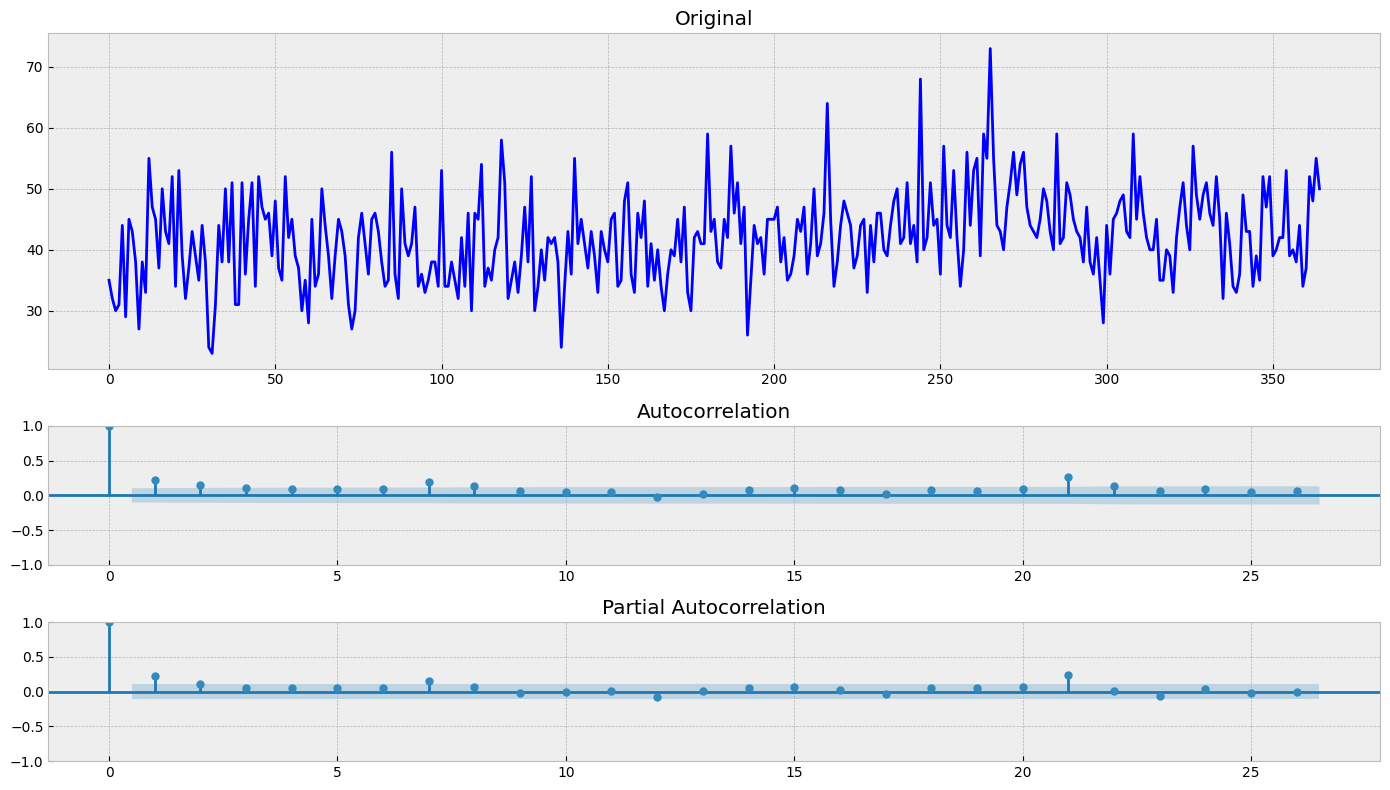

In [87]:
series =  female_births
tsplot(series)

In [196]:
series = female_births

#### оптимизация DEMA

In [194]:
len(series)

365

In [197]:
# делим на тест, трейн, вилидационную выборки
train, test, val = series[:200], series[200:300], series[300:]

In [201]:
param_a_b = {'01':[0.05, 0.2],
             '02':[0.1, 0.5],
             '03':[0.5, 0.5],
             '04':[0.5, 0.9],
             '05':[0.3, 0.7]
}

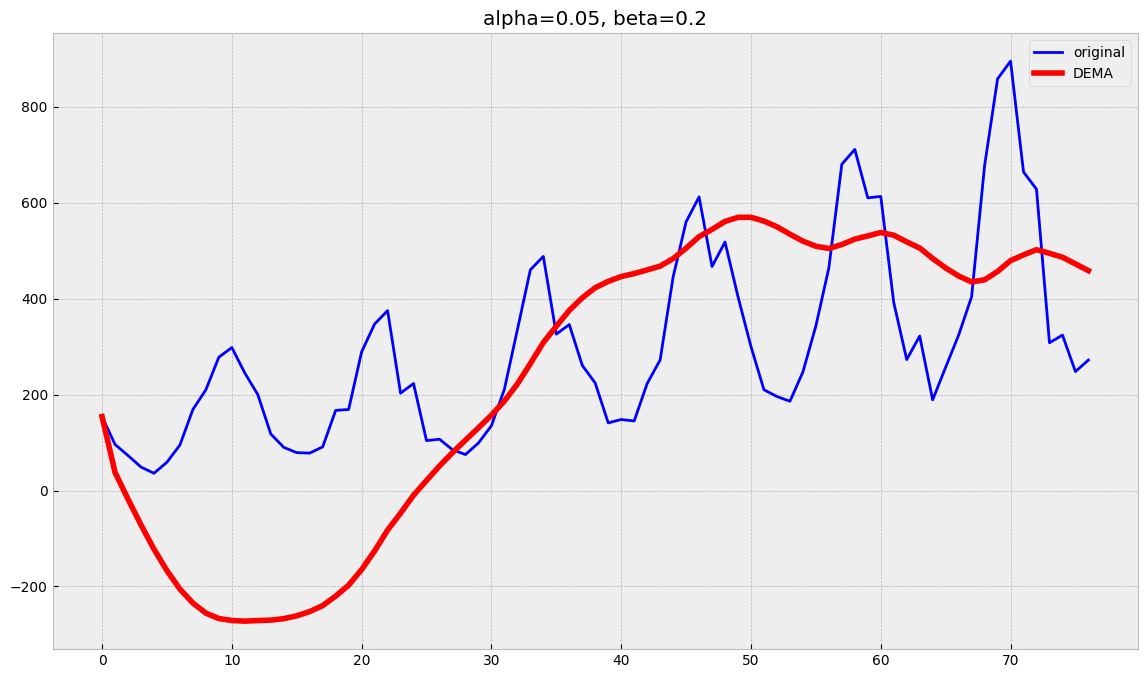

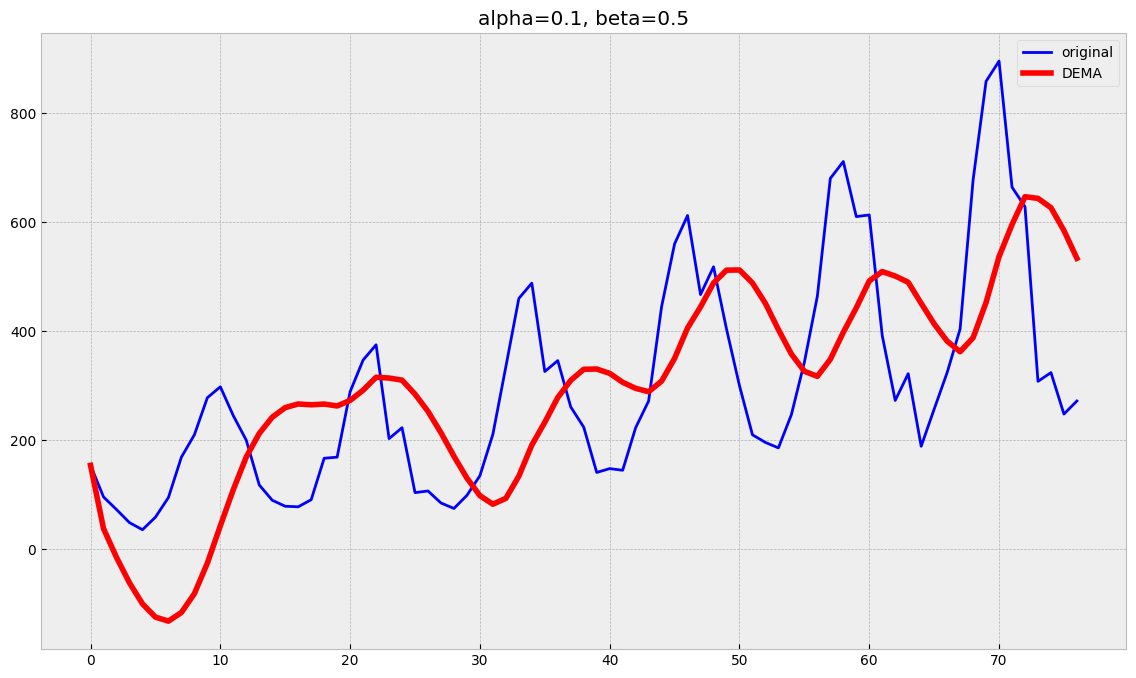

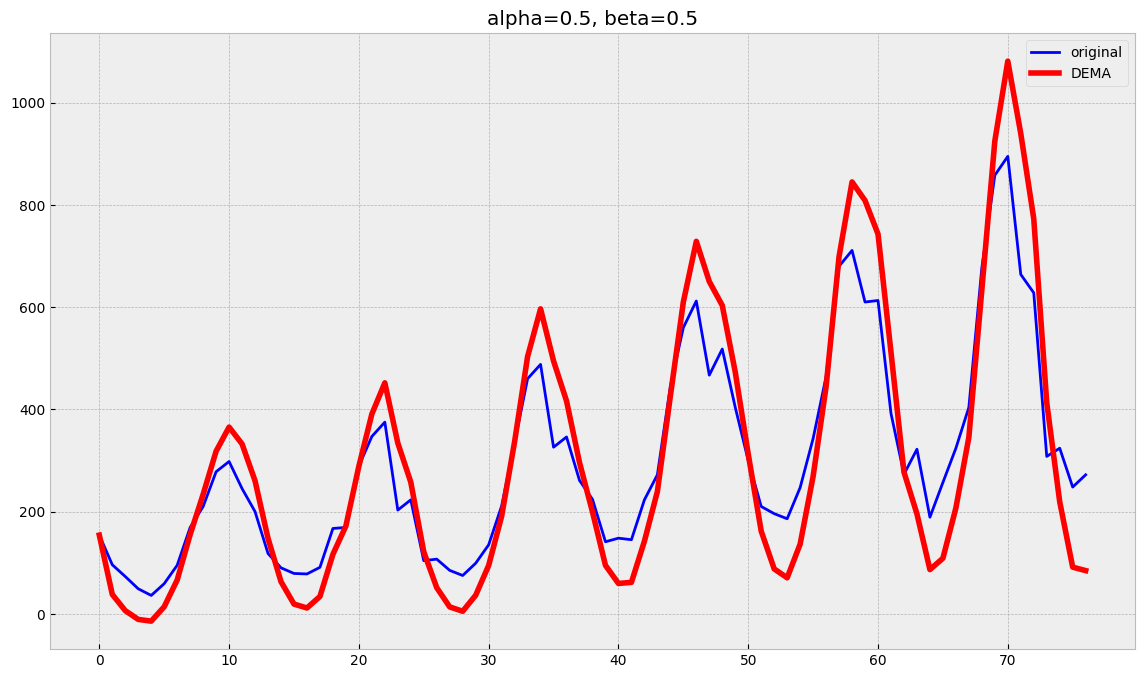

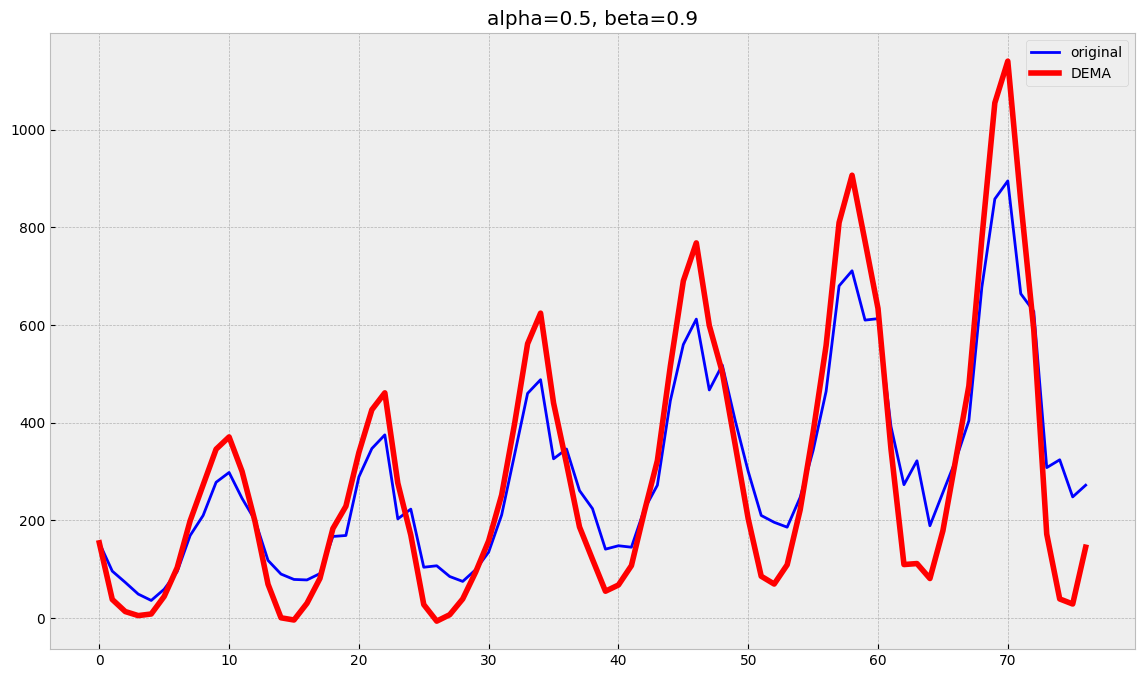

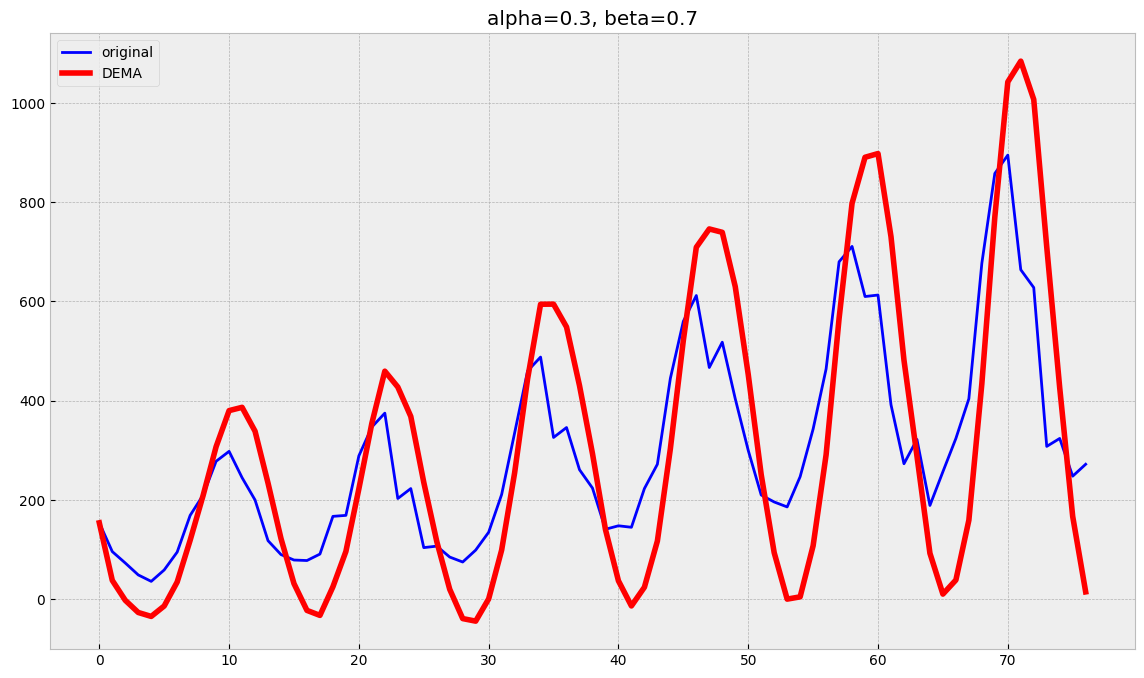

In [208]:
for v in param_a_b.values():
    a, b = v
    plot_dema(a, b)

Результат не очень хороший, поэтому пробуем TEMA

#### оптимизация и TEMA

In [192]:
# оптимизация с перебором разных методов
method = ['Nelder-Mead', 'Powell', 'L-BFGS-B', 'TNC', 'SLSQP', 'trust-constr'] # перебор по методам
res_opt = {}
for i in method:
    opt = minimize(mse, x0=[0,0,0], method=i, bounds = ((0, 1), (0, 1), (0, 1)))
    res_opt[i] = opt

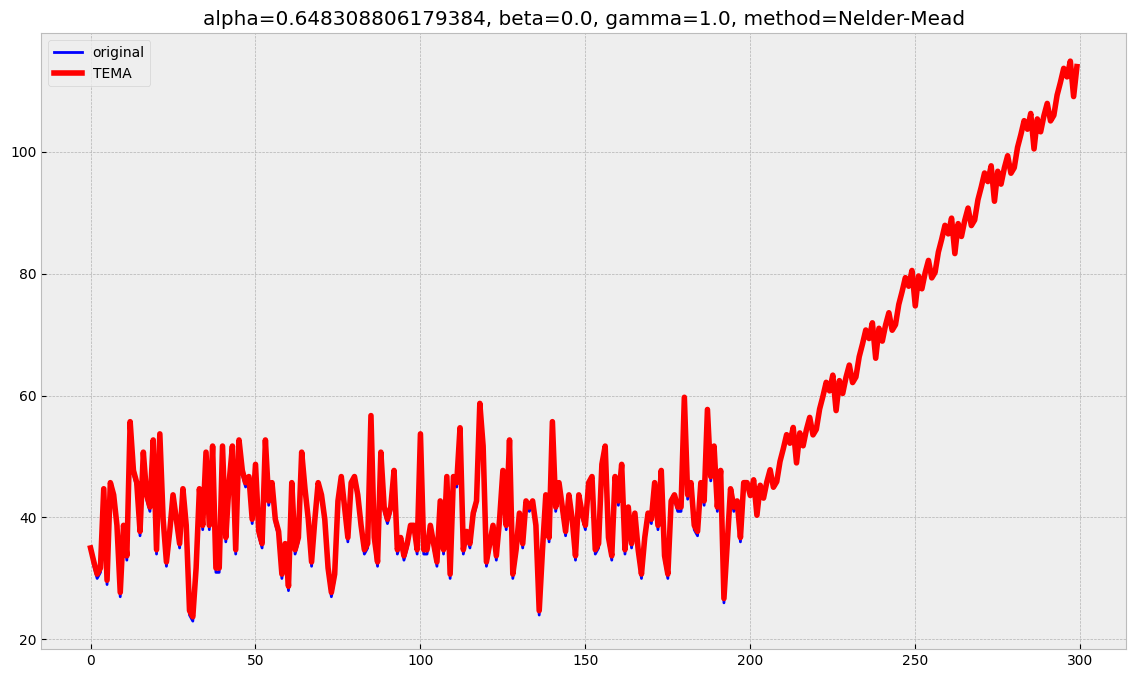

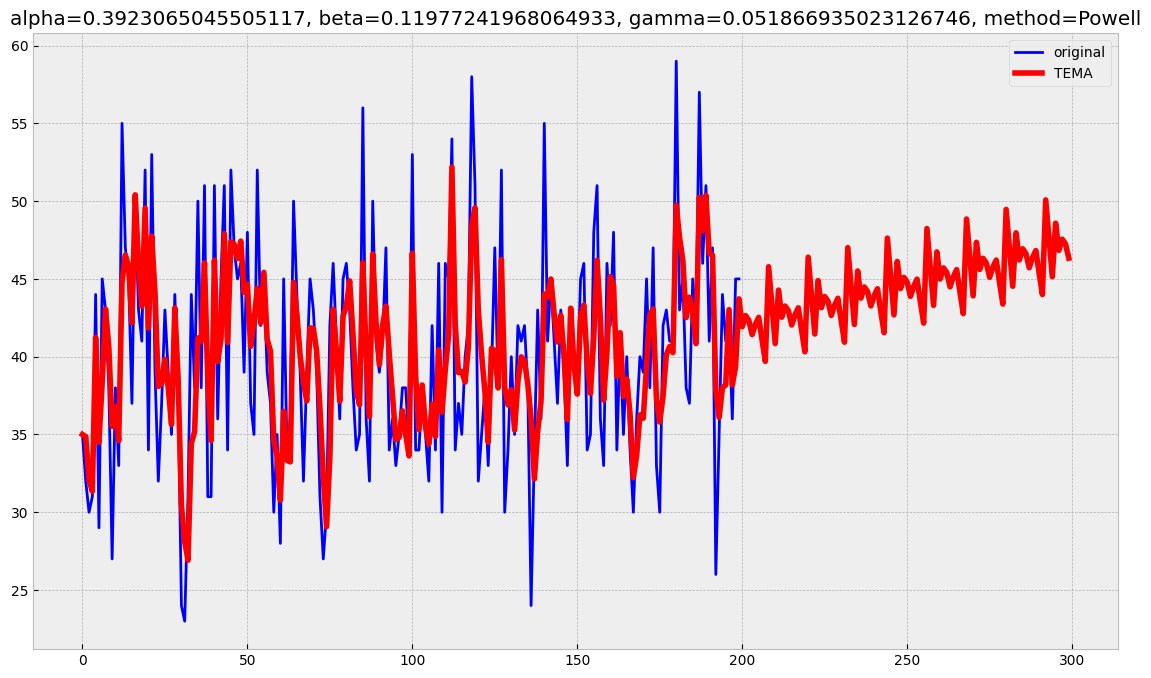

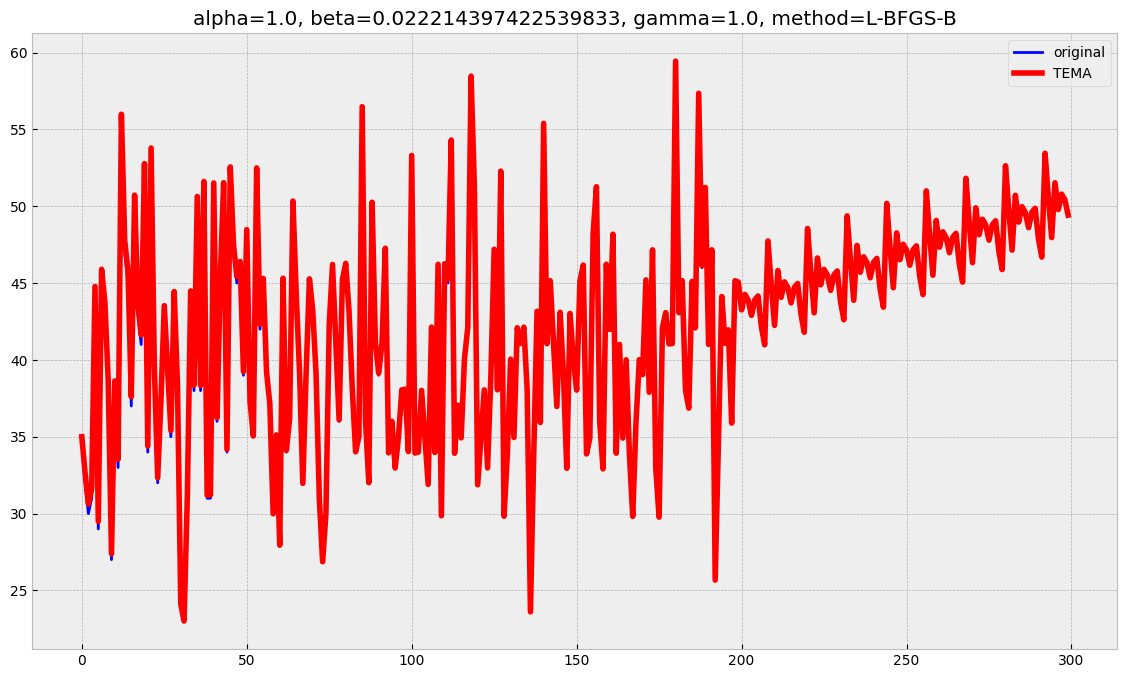

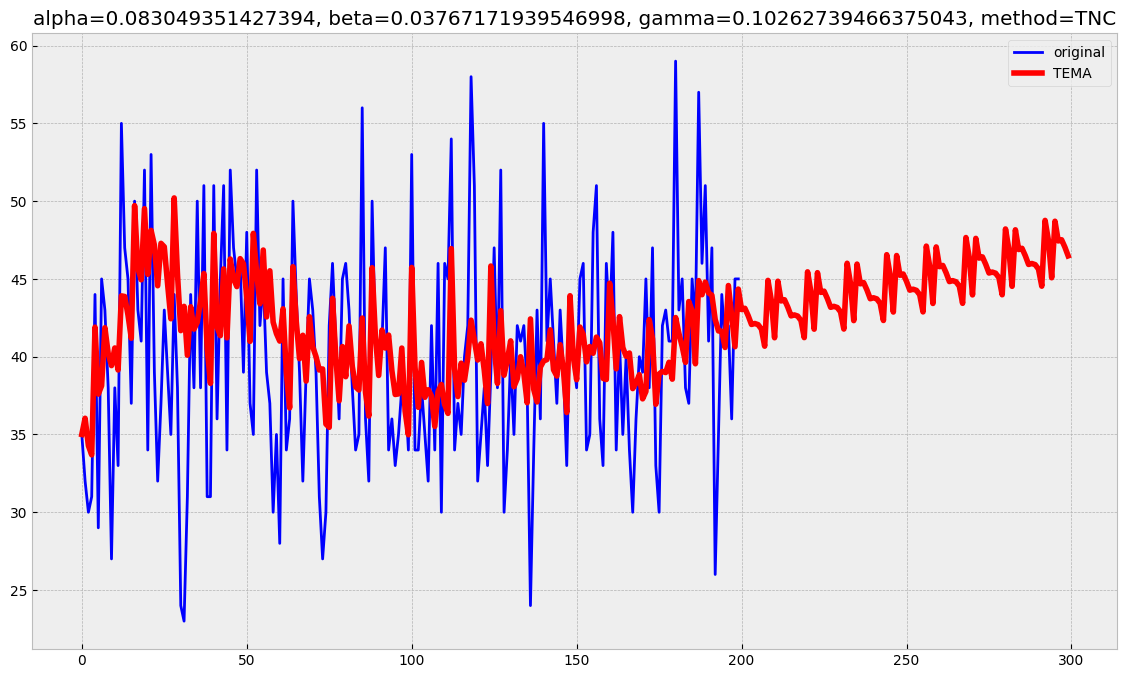

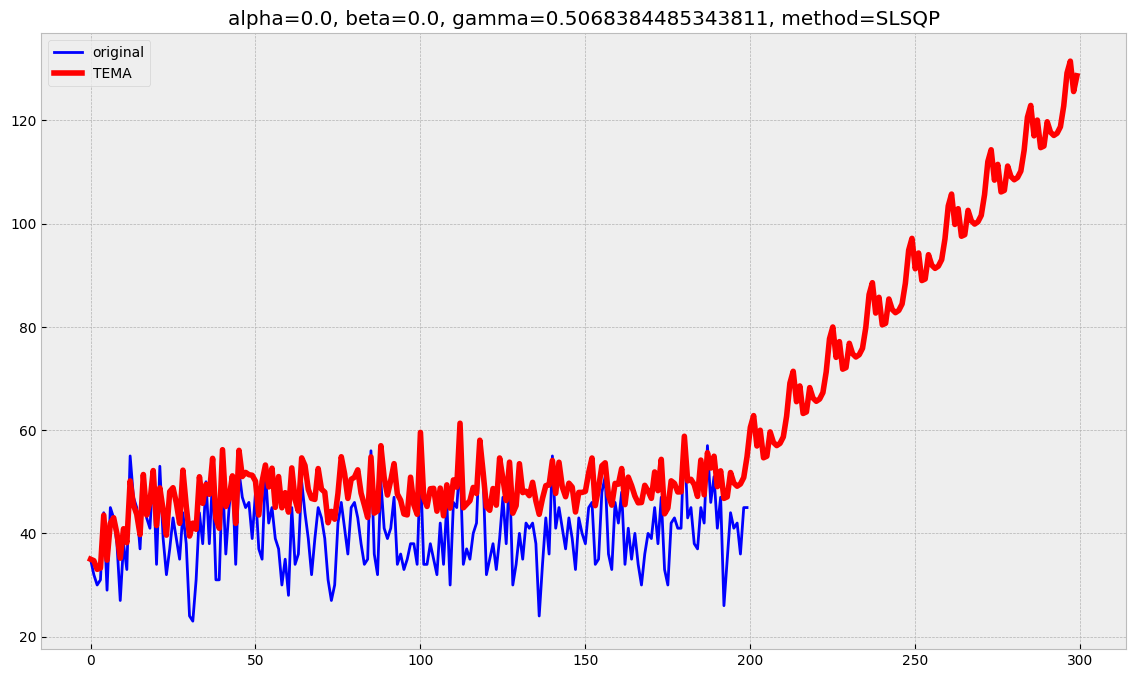

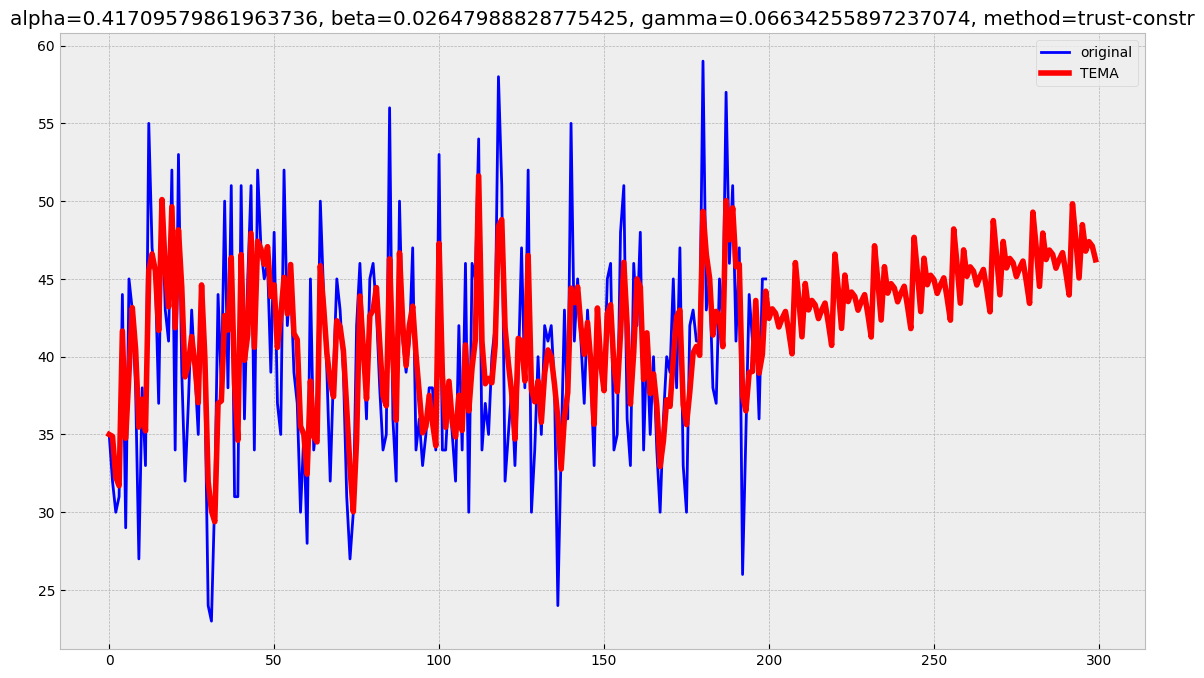

In [169]:
for k, v in res_opt.items():
    alpha_opt, beta_opt, gamma_opt = v.x
    plot_tema_m(alpha_opt, beta_opt, gamma_opt, k, ser=train, ser_to_plot=train, n_preds=len(test))

Лучший результат у функции оптимизации 'L-BFGS-B'

#### кроссвалидация

In [ ]:
# оптимизация с перебором разных методов
method = ['Nelder-Mead', 'Powell', 'L-BFGS-B', 'TNC', 'SLSQP', 'trust-constr'] # перебор по методам
res_opt = {}
for i in method:
    opt = minimize(mse_cross_val, x0=[0,0,0], method=i, bounds = ((0, 1), (0, 1), (0, 1)))
    res_opt[i] = opt

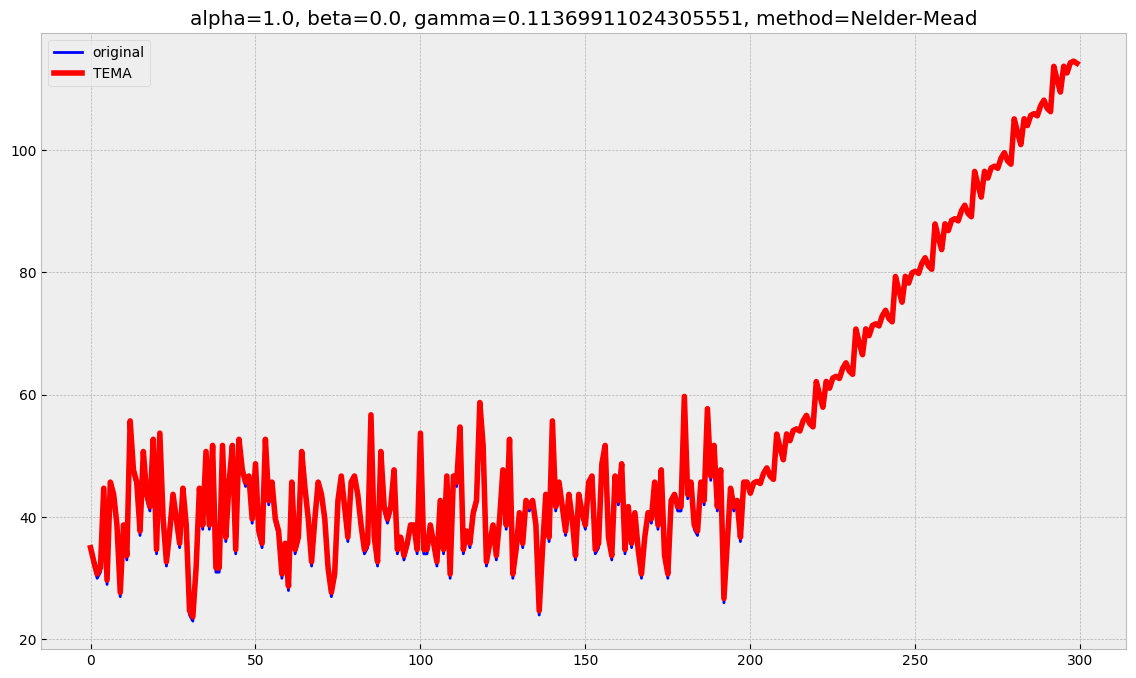

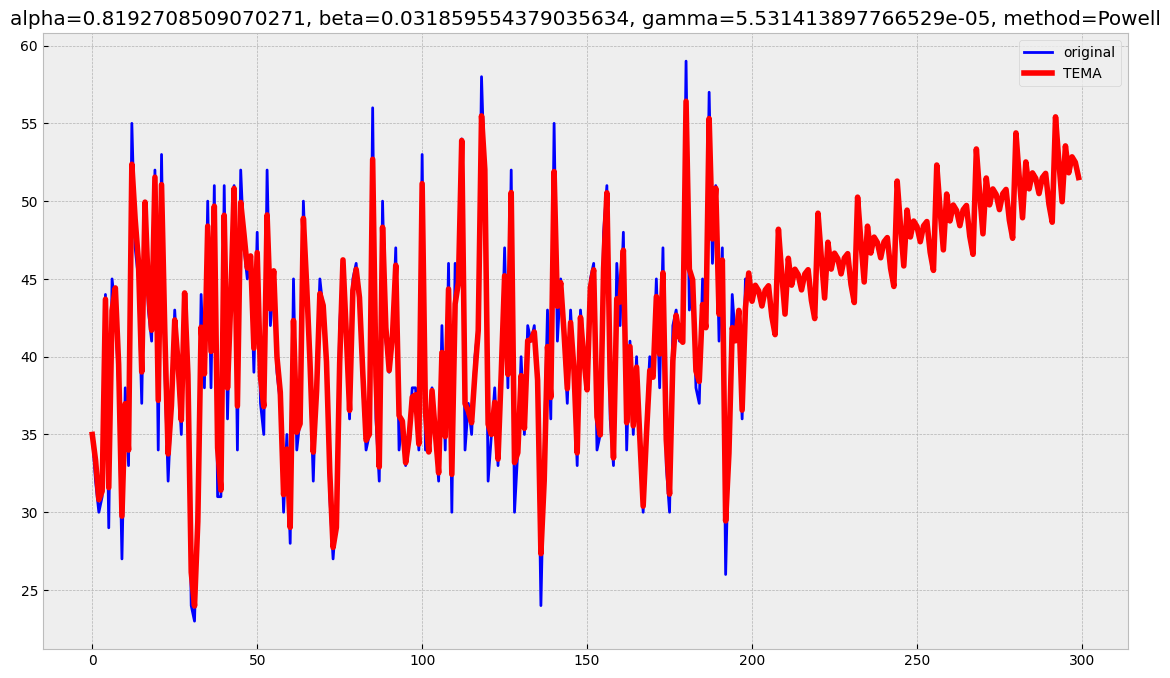

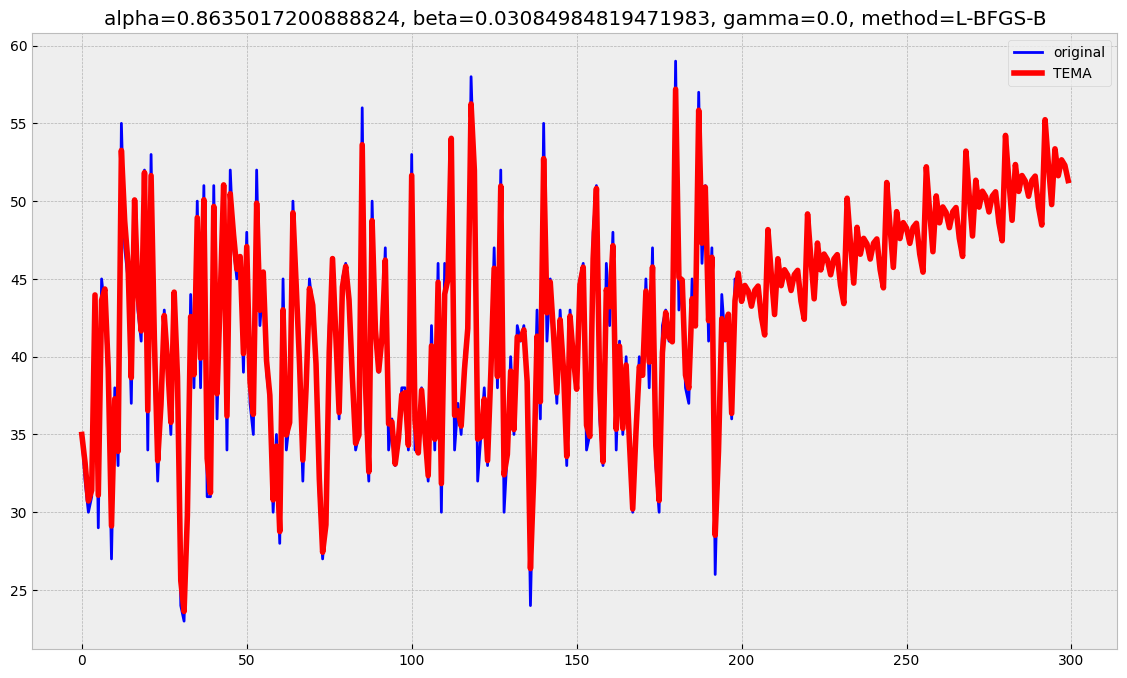

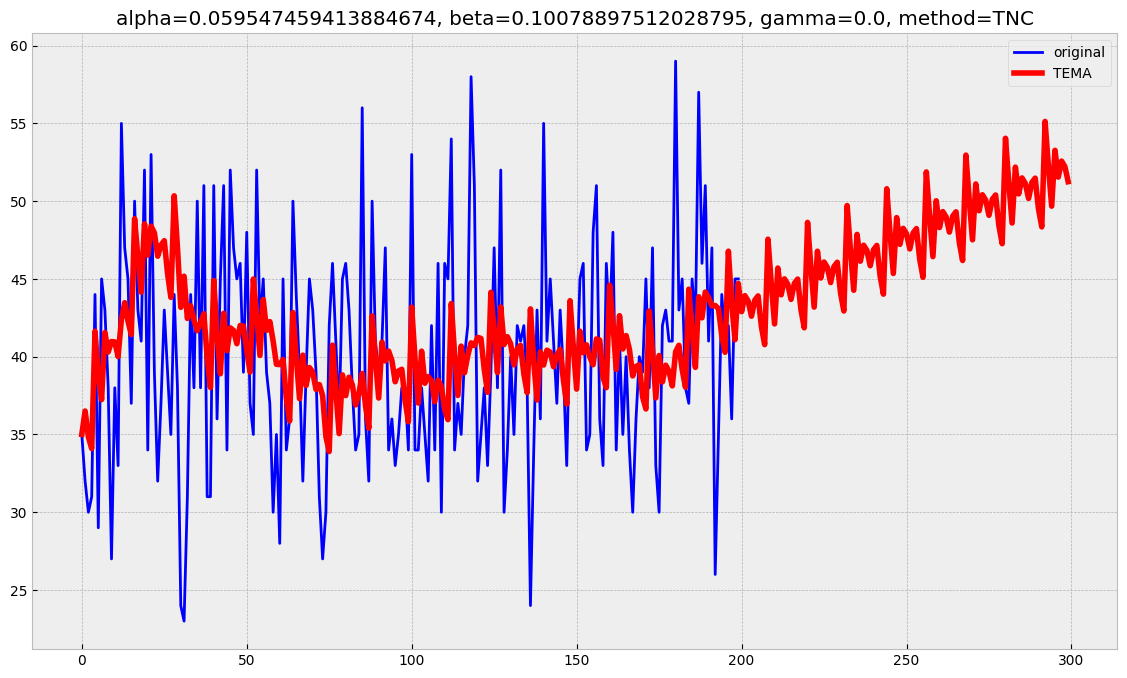

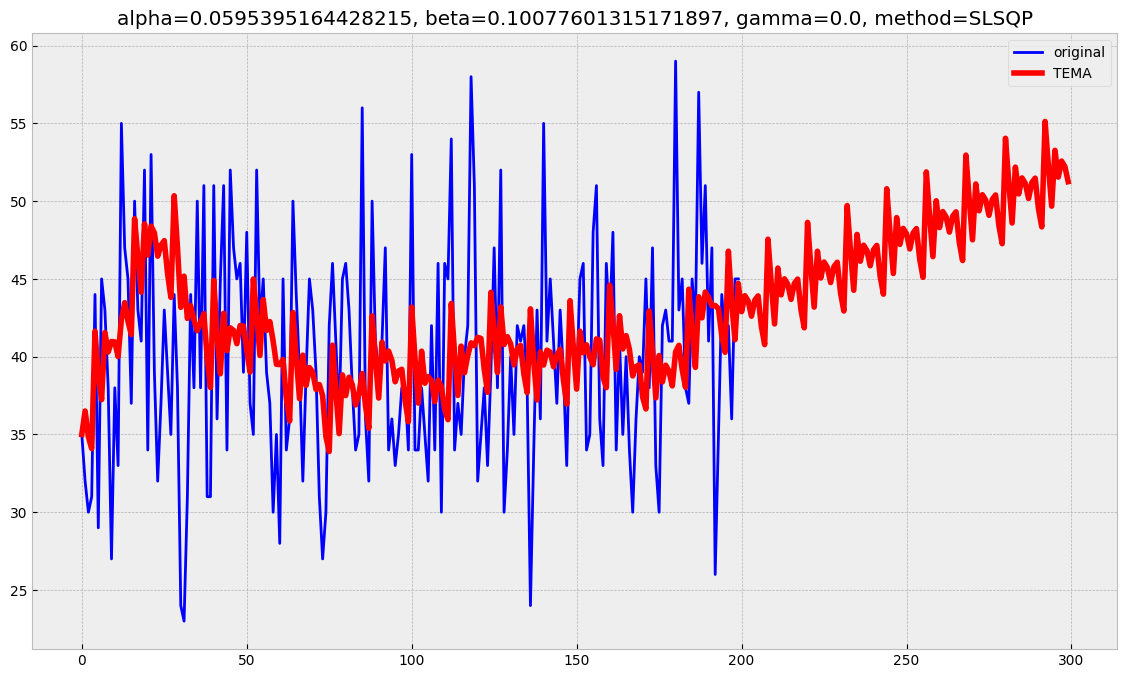

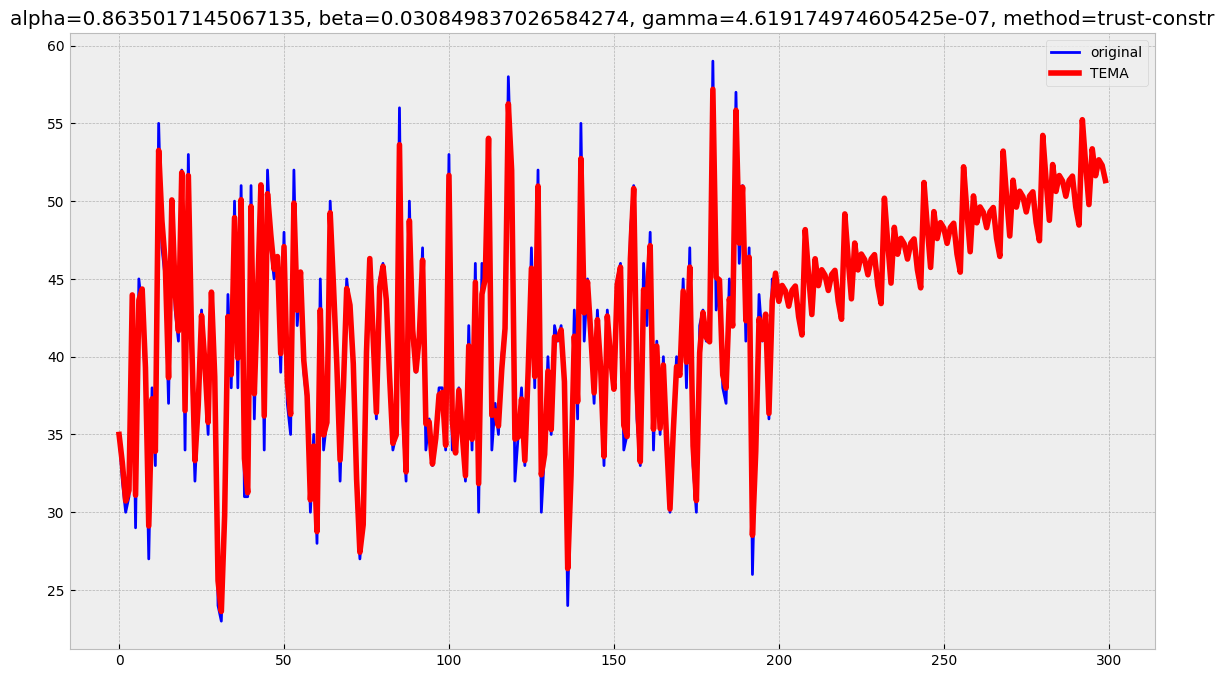

In [180]:
for k, v in res_opt.items():
    alpha_opt, beta_opt, gamma_opt = v.x
    plot_tema_m(alpha_opt, beta_opt, gamma_opt, k, ser=train, ser_to_plot=train, n_preds=len(test))

ВЫВОД: на обоих рядах, судя по графикам, лучше отработал метод TEMA, с применением функции оптимизации 
Powell', 'L-BFGS-B', 'trust-constr'